# Центрирование снимков google tiles api

#### Настройка сессии

In [1]:
import requests
import json

import pandas as pd
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt

import io
import sys
sys.path.append('../utils')

In [ ]:
API_KEY = <>

In [3]:
url = f'https://tile.googleapis.com/v1/createSession?key={API_KEY}'
headers = {'Content-Type': 'application/json'}
data = {
    'mapType': 'satellite',
    'language': 'en-US',
    'region': 'US'
}

response = requests.post(url, json=data, headers=headers)
session_token = json.loads(response.text)['session']

#### Mercator projection и inverse mercator projection, получение координат тайлика по широте и долготе

In [4]:
def mercator_project(lat, lon):
    
    mercator = -np.log(np.tan((0.25 + lat / 360) * np.pi))

    xp = 256 * (lon / 360 + 0.5)
    yp = 128 * (1 +  mercator / np.pi)

    return xp, yp

In [5]:
def inverse_mercator_project(xp, yp):
  
  lon = 360 * (xp / 256 - 0.5)

  mercator = (yp / 128 - 1) * np.pi
  lat = (np.arctan(np.exp(-mercator)) / np.pi - 0.25) * 360


  return lat, lon

In [6]:
lat, lon = 55.669529, 37.467527

xp, yp = mercator_project(lat, lon)
lat_, lon_ = inverse_mercator_project(xp, yp)

assert(np.allclose(np.array([lat, lon]), np.array([lat_, lon_])))

In [7]:
def get_google_xy_coords(lat, lon, z):

    xp, yp = mercator_project(lat, lon)
    print(f'Mercator projection: {xp=} {yp=}')

    scale = 2 ** z

    x = int(np.floor(xp * scale / 256))
    y = int(np.floor(yp * scale / 256))

    print(f'Tile coordinates: {x=} {y=}')

    return x, y

#### Скачивание тайлика 

In [8]:
def download_google_map_tile(x, y, session_token=session_token, api_key=API_KEY):

    url = f'https://tile.googleapis.com/v1/2dtiles/{z}/{x}/{y}'
    params = {
        'session': session_token,
        'key': api_key
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        return Image.open(io.BytesIO(response.content))
    else:
        raise Exception

#### Получение широты и долготы уголков тайлика

In [9]:
# мой дом
# lat, lon, z = 55.669529, 37.467527, 17

# наше общежиитие
lat, lon, z = 59.936882, 30.243140, 17

x, y = get_google_xy_coords(lat, lon, z)

Mercator projection: xp=149.5062328888889 yp=74.4319903683716
Tile coordinates: x=76547 y=38109


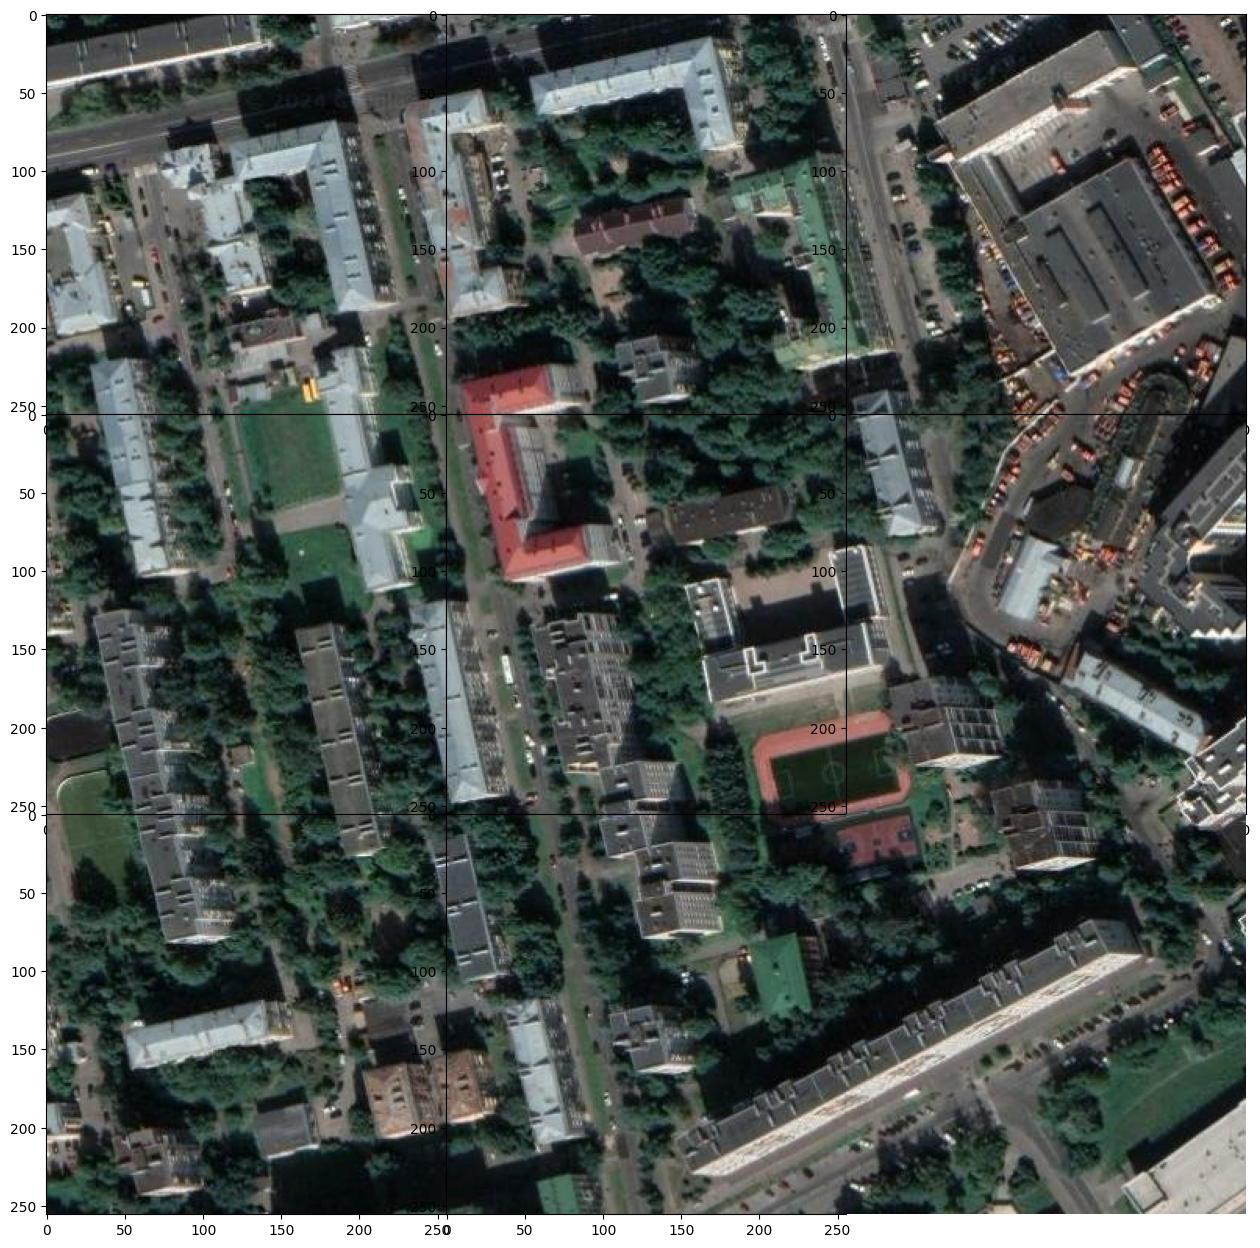

In [10]:
imgs = {
    (xt, yt): download_google_map_tile(xt, yt)
    for yt in (y - 1, y, y + 1)
    for xt in (x - 1, x, x + 1)
}


fig = plt.figure(figsize=(12, 12))

xt, yt = x - 1, y - 1
for i in range(9):
   plt.subplot(3, 3, i + 1)
   plt.imshow(imgs[xt, yt])
   if i % 3 == 2:
       xt = x - 1
       yt += 1
   else:
       xt += 1

plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
plt.axis('off')
plt.show()

Координаты верхнего левого угла тайлика

In [11]:
inverse_mercator_project(x * 256 / (2 ** z), y * 256 / (2 ** z))

(59.93712838146008, 30.24261474609375)

Координаты центра тайлика

In [12]:
lat_tile, lon_tile = inverse_mercator_project((x + 0.5) * 256 / (2 ** z), (y + 0.5) * 256 / (2 ** z))
lat_tile, lon_tile

(59.936440424186266, 30.243988037109375)

#### Склеиваем 9 тайликов вокруг нужного и обрезаем картинку

In [13]:
tiles = []
for xt in range(x - 1, x + 2):
  for yt in range(y - 1, y + 2):
      tiles.append(download_google_map_tile(xt, yt))

In [14]:
merged_image = Image.new('RGB', (256 * 3, 256 * 3))
for i, tile in enumerate(tiles):
  merged_image.paste(tile, ((i // 3) * 256, (i % 3) * 256))

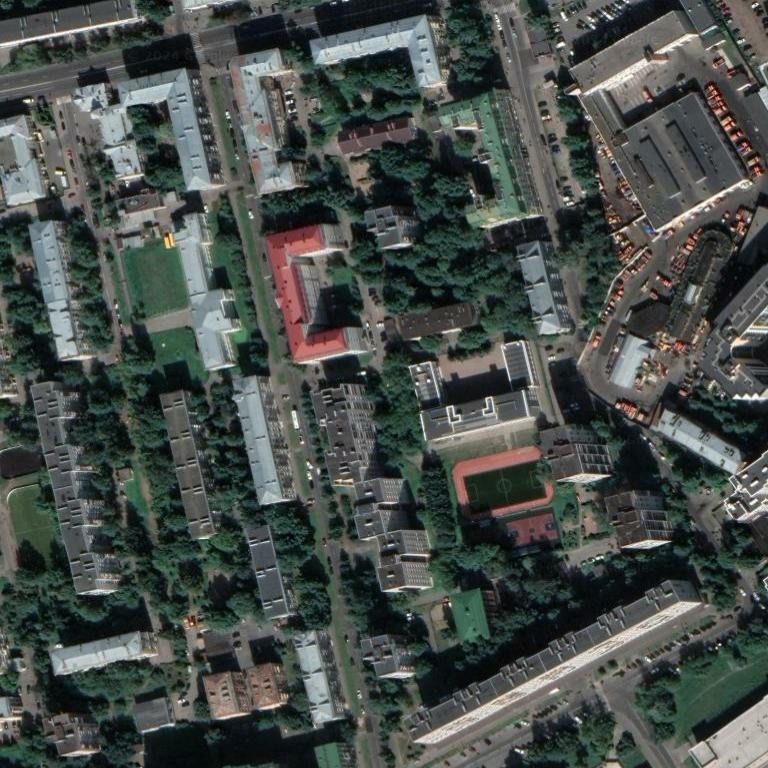

In [15]:
merged_image

In [16]:
xp, yp = mercator_project(lat, lon)
xp, yp = xp * (2 ** z), yp * (2 ** z)

xp_tile, yp_tile = mercator_project(lat_tile, lon_tile)
xp_tile, yp_tile = xp_tile * (2 ** z), yp_tile * (2 ** z)

offset_x, offset_y = 256 - xp_tile + xp,  256 - yp_tile + yp

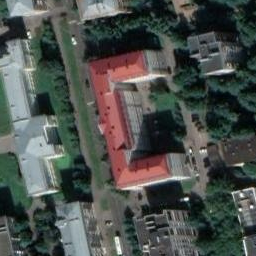

In [17]:
final_image = merged_image.crop((offset_x, offset_y, offset_x + 256, offset_y + 256))
final_image

## Использование готовой функции

In [18]:
from google_tile_centered_downloader import download_centered_image

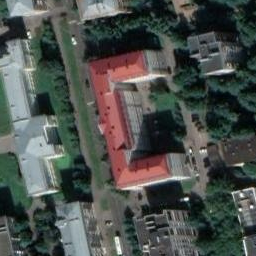

In [19]:
lat, lon, z = 59.936882, 30.243140, 17

download_centered_image(lat, lon, z, session_token, API_KEY)